# Классификация изображений собак и кошек
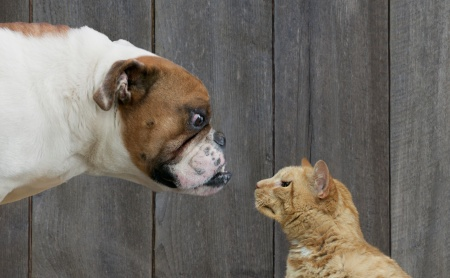

In [1]:
import os
import cv2
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# custom
from model import Net
from train import accuracy, train_model
from dataset import CatDogDataset, read_img_test

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ВАЖНО результат выполнения кода в этой ячейки должен быть cuda для правильного работы ноутбука
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device.type)

cuda


# Как мир видят компьютеры

Для компьютера нет такого понятия "изображение" есть только набор чисел. И любая фотография внутри компьютера представлена как таблица с разными числами.
Числа внутри таблицы отвечают за яркость. Чем выше значение(максимальное 255), тем ярче фото в этой части.
Такие таблицы с числами принято называть матрицами. Ниже нарисовано число с помощью чисел внутри таблицы. Попробуйте угадать, какое число нарисовано в ячейке ниже.

In [3]:
# Попробуйте угадать, что изображено
digit = [
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 255, 255, 255, 255, 255, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 224, 100, 100, 255, 100, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 155, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 222, 220, 235, 235, 245, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

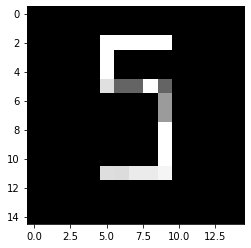

In [4]:
# Ответ
import numpy as np
digit = np.array(digit)
plt.imshow(digit, cmap=plt.get_cmap('gray'))

Код в следующей ячейке случайным образом выбирает 5 фотографий и выводит их на экран.

Выберете следующую ячейку и нажмите ctrl+Enter несколько раз, чтобы получить разные фотографии

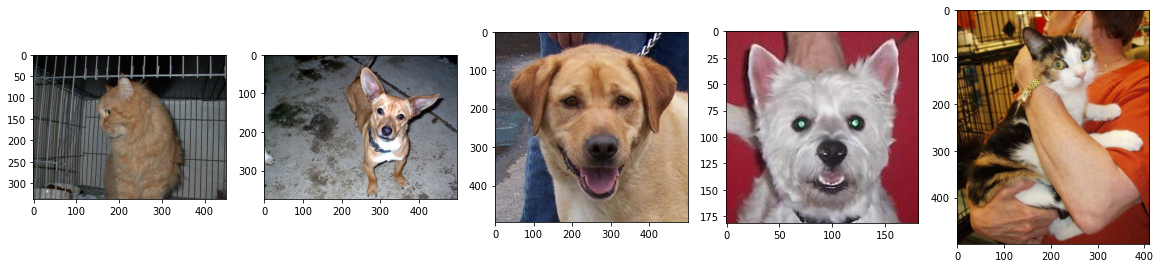

In [5]:
import random

rand_files = random.sample(os.listdir('train'), 5)

fig, ax = plt.subplots(1, 5, figsize = (20,10))
for i, file in enumerate(rand_files):
    img = cv2.imread(f'train/{file}', cv2.IMREAD_COLOR) 
    #  cv2.cvtColor меняет слои в изображении, чтобы они не выглядели синими
    #  Ради интереса можете закоментить следующую строку ctrl+/
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].imshow(img)

Мы уже говорили, что фото представлено как таблица с числами, которые отвечают за яркость в диапазоне от 0 до 255. 
Но это верно только для черно-белого изображения. Цветные фотографии представленны немного по другому.
Вместо одной таблицы, таких таблиц 3 и каждая из них отвечает за определенный цвет RGB(red(красный), green(зеленый), blue(голубой)).
Если разложить фото на цвета, то оно будет выглядеть следующим образом. Выполните код в ячейке ниже, чтобы увидеть.

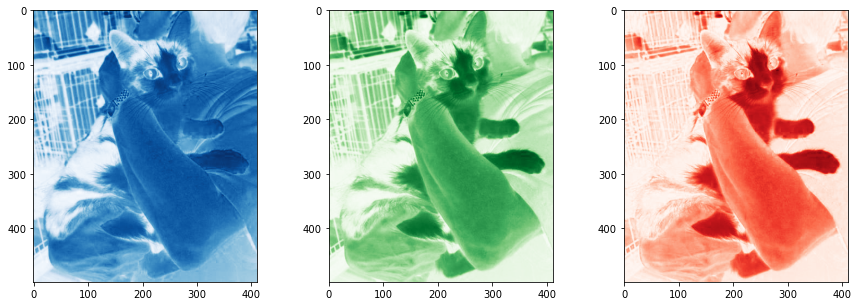

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (15,5))
ax[0].imshow(img[:,:,0], plt.get_cmap('Blues'))
ax[1].imshow(img[:,:,1], plt.get_cmap('Greens'))
ax[2].imshow(img[:,:,2], plt.get_cmap('Reds'))

Если посмотреть размеры нашего фото, то мы увидим кортеж(тип данных внутри языка python) из 3 чисел:
первое число это высота изображения,
второе число это длина изображения,
и последнее отвечает за количество таблиц(матриц) внутри изображения.
Высота и длина представлены в пикселях - это минимальное значение изображени. Мельчайшая точка на вашем экране.

In [7]:
img.shape

(499, 411, 3)

# Работа с данными

Для того, чтобы натренировать нашу модель отличать котов от собак, мы будем постепенно шаг за шагом показывать ей набор картинок(batch) и говорить ей кто есть кто.
Так мы будет делать пока в наших тренировочных данных не закончатся картинки(таких у нас 2000). После этого мы будем измерять насколько хорошо она справилась, показывая ей картинки, которые она не видела из тестовых данных(таких у нас 500) и спрашивать, что она думает там изображено. Но перед тем, как показывать нашей модели картинки их нужно сделать одного размера(одинаковой высоты и ширины) и присвоить название(является ли данная картинка собакой или котом). Поскольку, когда мы тренируем нашу модель, то показываем ей что на картинке, а когда тестируем, то нет. То нам потребуется две разные загрузочные функции чтобы формировать наборы картинок и ответов.

In [8]:
train_dataset = CatDogDataset(mode="train")
test_dataset = CatDogDataset(mode="val")

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

In [9]:
# практическая часть написать получение одного batch данных из train_data_loader
img_batch = None
label_batch = None

# Решение
for imgs, labels in train_data_loader:
    img_batch = imgs
    label_batch = labels
    break

Поскольку мы выбрали batch_size = 16, то у нас получается формируется 16 наборов картинок и 16 значений ответов, что на картинке

In [10]:
print(img_batch.shape)
print(label_batch.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


Как мы уже обсуждали раньше для компьютера не существует изображения, а только набор из таблиц(матриц) с числами.
Но компьтер точно также не понимает и человеческие слова. Но для того, чтобы нам натренировать модель необходимо
каким-то образом ему сообщить что изображено на фото. Для этого мы специально закодировали обозначение класса изображения(кошка это или собака).
Попробуйте угадать, основываясь на результатах выполнения кода в следующей ячейке, какое значение обозначает класс собак, а какое кошек. 
Как по вашему мы бы поступили, если бы у нас было больше классов?

Класс: 0.0


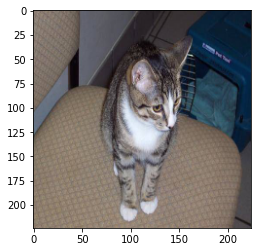

In [11]:
indx = 2 #Это значение можно менять в пределах от 0 до 15
print('Класс:', label_batch[indx].item())
plt.imshow(img_batch[indx].permute(1, 2, 0))

# Модель

При выполнение кода в следующей ячейке мы задаем нашу нейронную сеть и выводим про нее статистику.
Нейронные сети обычно обладают большим кол-вом разнообразных слоев. Отсюда и название "глубокое" обучение("Deep learning") поскольку
у нас получается "глубокая" модель. Несмотря на название "нейронная сеть" наша модель с нейронами головного мозга почти не имеет ничего общего.
Наша модель представляет собой набор последовательных операций над числами внутри нашего изображения.
Все эти операции приводят к тому, что на выходе наша модель должна вывести одно значение от 0 до 1. Это значение будет показывать
насколько наша модель "уверена" в том, что на изображение собака. Соответственно, если модель совсем не уверена, что это собака, то на изображении кошка.

In [12]:
from torchsummary import summary
model = Net()
model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           4,864
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         Dropout2d-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6         [-1, 32, 112, 112]          18,464
       BatchNorm2d-7         [-1, 32, 112, 112]              64
              ReLU-8         [-1, 32, 112, 112]               0
         Dropout2d-9         [-1, 32, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]           4,624
      BatchNorm2d-11         [-1, 16, 112, 112]              32
             ReLU-12         [-1, 16, 112, 112]               0
        Dropout2d-13         [-1, 16, 112, 112]               0
        MaxPool2d-14           [-1, 16,

Давайте поговорим немного про нашу модель. Ее размер составляет целых 124 мгб. И по сравнению со многими другими моделями машинного обучения мы можем сказать, что наша модель достаточно легкая. Не редкость, что обьем модели может достигать нескольких гигабайт. Output Shape - показывает как меняется измерения нашей картинки. Мы принимаем на вход (3, 224, 224). Но уже после первого слоя, кол-во матриц вырастает до 64! Можно заметить, что чем ближе наши данные к концу этого конвеера, тем меньше становится наше изображение, пока не превращается всего лишь в одно число.
Вы также можете заметить, что многие слои внтури нашей модели повторяются.
Давайте рассмотрим некоторые из них более подробно.

## Conv2d слой
Этот слой производит операцию, которая называется страшным слоем "конволюция".
Но на самом деле страшного и сложного здесь ничего нет.
Происходит следующее: определенный фильтр(изображен вторым по порядку) последовательно накладывается на
одну из таблиц(матриц) нашего изображения. Числа внутри таблицы изображения умножаются последовательно на числа внутри
фильтра и все это складывается. В итоге получается 1 число. Подробно процесс на гифке ниже.

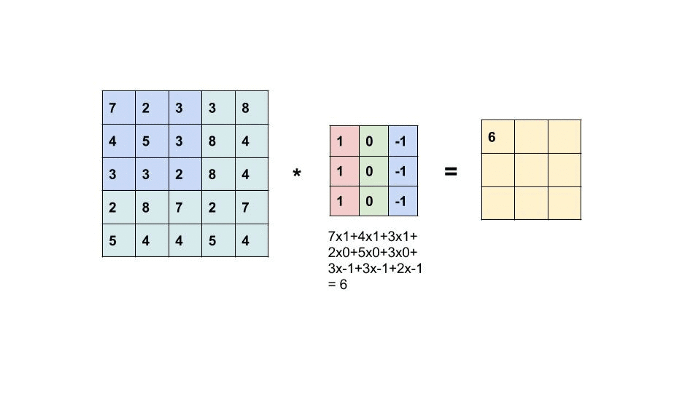

## Dropout2d
Целью данного слоя является время от времени "выключать" некоторые части нашей модели в процессе тренировки.
Наша модель от природы очень умная. И часто любит хитрить. Вместо того, чтобы пытаться понять чем отличаются изображения собак от кошек
модель может просто "зазубрить" где в тренировочных данных фото кошек, а где собак. И потом, когда она встречается с изображениями за пределами
тренировочных данных, которые она никогда не видела, то справляется с задачей очень плохо. Для этого мы время от времени будем лишать нашу модель всей своей интеллектуальной мощи.

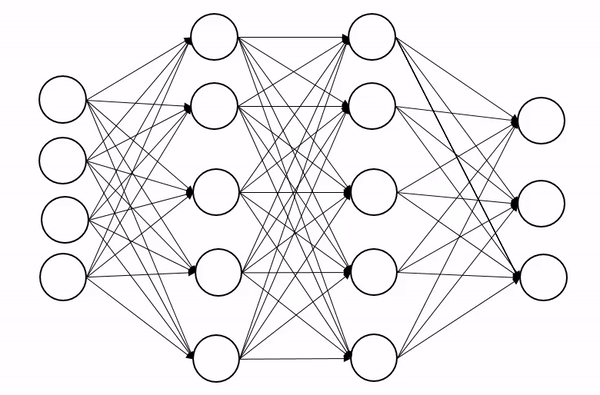

## MaxPool2d
Этот слой производит выбор наибольшего числа из области определенного размера.
На гифке ниже можно заметить как слой работает, если размер фильтра 2 на 2.

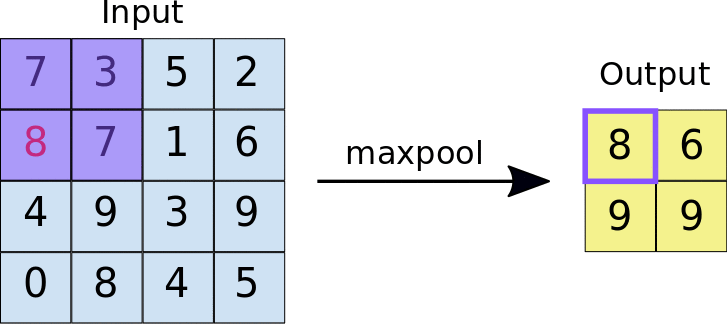

# Sigmoid

Наш предпоследний слой Linear выдает число, которое может принимать любые значения от -inf до +inf.
Чем меньше число, тем меньше шанс того, что на изображение собака и больше шанс, что на изображении кот.
Но этими числами трудно оперировать. К примеру что значит число 129? Насколько модель уверена, что на фото собака,а если число равно 10? Как насчет -200?
Поэтому мы приводим все к единой шкале от 0 до 1 с ипользованием сигмоидной функции. 
И тогда сразу видно, что если число больше чем, 0,5 то модель считает, что на фото собака, а если меньше, чем 0,5 то кошка.
Получить интуицию, как это работает, можно в следующей ячейке,
подставляя разные числа в эту функцию, которая определена в python.

In [13]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

num = -9 # Попробуйте менять разные числа от -inf до +inf
sigmoid(num)

0.00012339457598623172

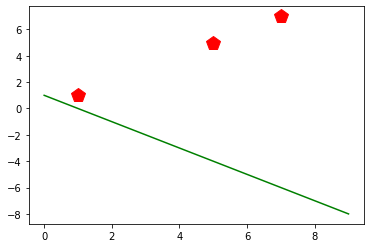

In [14]:
# Задача: фунцкция y = x*b + k описывает прямую на плоскости. Где b это угол наклона а k это сдвиг. Подберите правильне значения для
# b и k такие, что линия начнет правильно описывать заданные точки. 

b = -1 #угадай правильное значение
k = 1 #угадай правильное значение
x = np.array(list(range(0, 10)))
y = x*b + k

plt.plot(1, 1, 'rp', markersize=14) 
plt.plot(5, 5, 'rp', markersize=14) 
plt.plot(7, 7, 'rp', markersize=14) 
plt.plot(x, y, '-g')  # solid green

# Решение b = 1, k = 0

Отлично! Вы справились. Осталось повторить тоже самое с 78353 параметрами нашей нейронной сети и все готово.
А если серьезно, то именно для того, чтобы найти эти параметры мы и "тренируем" нашу модель. Иными словами мы её постепенно шаг за шагом оптимизируем.
Примерно также, как мы делали в примере выше. Для этого используются сложные механизмы. Про них мы пока говорить не будем.

### Тренировка нашей модели

In [53]:
# Наш оптимизатор, его зовут Адам
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
# Мы будем менять шаг со временем, когда приближаемся к оптимальному значанию
# как мы делали выше. Чем ближе мы к концу, тем меньше значения мы придавали b и k
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)
# Наш критерий того, движемся ли мы в правильном направлении или нет.
# Нашем критерии в задаче выше был наш глаз. Мы зрительно оценивали лучше мы сделали или нет. Эту же задачу выполняет наш criterion здесь
criterion = nn.BCELoss()

# кол-во эпох тренировки
EPOCHS = 4


# Переводим нашу модель на графическую карту
model.to(device)
# Запускаем процесс тренироки
logs = train_model(EPOCHS, 
                    model, 
                    train_data_loader, 
                    test_data_loader, 
                    optimizer, criterion)

  0%|          | 0/313 [00:00<?, ?it/s]

Тренировка
Эпоха 1 Точность: 80.81 Время : 48.8256 

  0%|          | 0/1250 [00:00<?, ?it/s]

Проверка
Эпоха 1 Точность: 76.9169 Время : 5.5184 

  0%|          | 0/313 [00:00<?, ?it/s]

Тренировка
Эпоха 2 Точность: 82.7 Время : 48.848 

  0%|          | 0/1250 [00:00<?, ?it/s]

Проверка
Эпоха 2 Точность: 75.7588 Время : 5.6228 

  0%|          | 0/313 [00:00<?, ?it/s]

Тренировка
Эпоха 3 Точность: 84.625 Время : 49.9584 

  0%|          | 0/1250 [00:00<?, ?it/s]

Проверка
Эпоха 3 Точность: 76.5974 Время : 6.1937 

  0%|          | 0/313 [00:00<?, ?it/s]

Тренировка
Эпоха 4 Точность: 85.445 Время : 50.9143 

100%|██████████| 313/313 [00:05<00:00, 54.64it/s]

Проверка
Эпоха 4 Точность: 76.278 Время : 5.73 

Мы тренировали нашу модель 4 эпохи. Эпохой в машинном обучении называют проход по всем данным, тестовым и тренировочным, которые у нас имеются. Можно заметить, что наша модель сделала 1250 шагов, когда мы её тренировали и 313, когда мы делали проверку. Можете предположить почему имеено столько шагов?(Ответ: наш batch 16, тоесть мы за один шаг показывам модели 16 фото. отсюда 20000/16=1250) Точностью обозначается отношение угаданных моделью фото ко всем фото. Если у нас 100 фото и модель угадала правильно 60 из них, то точность модели составляет 60%. Чем больше модель угадывает, тем выше ее точность. У нас два показателя точности. Один при проверке, второй при тренировки. Поскольку когда мы тренируем модель, мы показываем ей правильный ответ, она начинает постепенно запоминать какое фото где. Из-за это можно заметить что точность при тренировке равномерно растет, а при проверке испытывает колебания. Это можно заметить на графиках ниже. Синяя линяя это точность тренировочная а зеленая точность проверки.

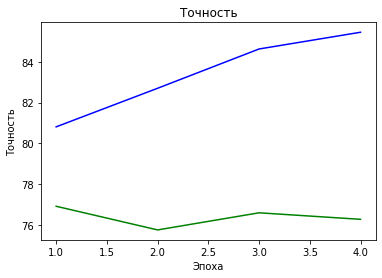

In [54]:
#Точность
plt.title("Точность")
plt.plot(np.arange(1, EPOCHS+1, 1), logs[0]["accuracy"], color = 'blue')
plt.plot(np.arange(1, EPOCHS+1, 1), logs[1]["accuracy"], color = 'green')
plt.xlabel("Эпоха")
plt.ylabel("Точность")
plt.show()

Помимо параметров модели, в машином обучение есть такое понятие как гиперпараметры. Это такие параметры, которые не зависят от модели, и задаются автором. Кол-во эпох это как раз такой гиперпараметр.
Четыре эпохи недостаточно, чтобы натренировать модель максимально. Попробуйте подобрать правильное значение самостоятельно. Каждый раз, когда выполняется код с тренировкой модели, она будет тренироваться еще дополнительно 3 эпохи. Тоесть если выполнить код еще раз, то модель будет тренироваться дополнительные 4 эпохи и того 8 и так далее.

In [65]:
os.listdir('custom_test')

['e78d8b0d8f4650e25bee66beb2d19d55.jpg', '0fh4nrc5alhzwwns40cej0duwec.jpg']

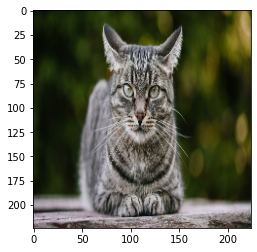

In [62]:
path = f"custom_test/0fh4nrc5alhzwwns40cej0duwec.jpg"
img = read_img_test(path)
plt.imshow(img[0].permute(1, 2, 0))

In [64]:
img = img.to(device)
model.eval()
with torch.no_grad():
    percentage = round(model(img).item(), 4)
    if percentage >= 0.5:
        print('Модель думает, что это собака')
    else:
        print('Модель думает, что это Кошка')

Модель думает, что это Кошка
